<a href="https://colab.research.google.com/github/tiasaxena/PySpark/blob/main/Pima_Indians_Diabetes_Database(using_PySpark).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Kaggle Competition Link](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) - Pima Indians Diabetes Database



In [3]:
! pip install kaggle
! pip install pyspark

! kaggle datasets download uciml/pima-indians-diabetes-database
! unzip pima-indians-diabetes-database.zip

Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
License(s): CC0-1.0
pima-indians-diabetes-database.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  pima-indians-diabetes-database.zip
  inflating: diabetes.csv            


## 0. Importing the libraries

In [58]:
import pyspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

## 1. Creating the Spark Session

In [9]:
spark = SparkSession.builder.appName('diabetes').getOrCreate()
spark

## 2. Loading the data

In [50]:
df = spark.read.format("csv")\
               .option("header", "true")\
               .option("inferschema", "true")\
               .load("/content/diabetes.csv")

df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



### View first 5 records of the df using Pandas

In [51]:
pd.DataFrame(df.take(5), columns=df.columns).head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Check if the dataset is balanced

In [52]:
df.groupBy("Outcome")\
  .agg(count("Outcome"))\
  .show()

+-------+--------------+
|Outcome|count(Outcome)|
+-------+--------------+
|      1|           268|
|      0|           500|
+-------+--------------+



### Statistic Summary

In [53]:
df.summary().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

### Correlation between independent variables

Since we don't have any plotting API in pyspark, we need to convert our Spark df to Pandas df first.

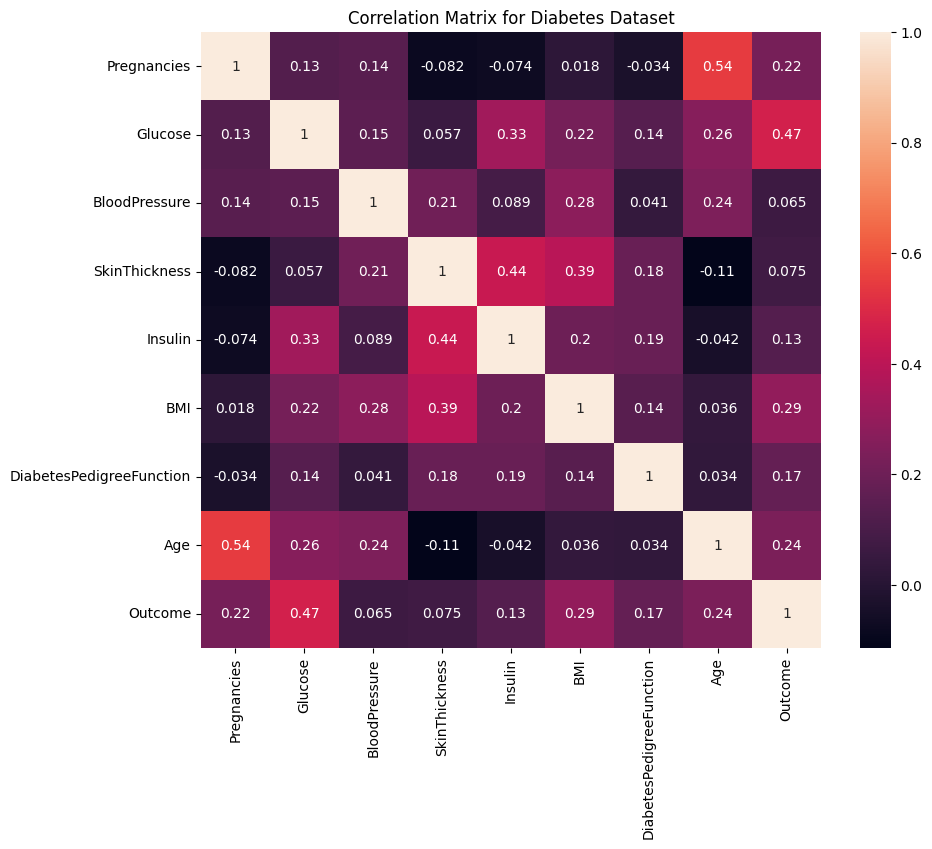

In [54]:
# Select the numerical columns
numerical_cols = [ col_dtype[0] for col_dtype in df.dtypes if col_dtype[1] in ['int', 'double', 'long']]

# Selct the corresponding numerical data
numerical_data = df.select(numerical_cols).toPandas()

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Plot the corrlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation Matrix for Diabetes Dataset")
plt.show()


Thus, we can consider dropping the following features, given that, they add a very little or not useful information to the model:
1. BloddPressure
2. SkinThickness
3. DiabetesPedigreeFunction
4. Insulin

In [55]:
df = df.drop('SkinThickness')
df = df.drop('Insulin')
df = df.drop('DiabetesPedigreeFunction')
df = df.drop('BloodPressure')

### Check & Fill, if any null values found

In [56]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias("Null_values_in_"+c+"_column") for c in df.columns]).show(truncate=False)

+---------------------------------+-----------------------------+-------------------------+-------------------------+-----------------------------+
|Null_values_in_Pregnancies_column|Null_values_in_Glucose_column|Null_values_in_BMI_column|Null_values_in_Age_column|Null_values_in_Outcome_column|
+---------------------------------+-----------------------------+-------------------------+-------------------------+-----------------------------+
|0                                |0                            |0                        |0                        |0                            |
+---------------------------------+-----------------------------+-------------------------+-------------------------+-----------------------------+



So, there are no missing values.

## 4. Convert features using `VectorAssembler`

In [66]:
# Select all the features to be assembled
required_features = df.columns
required_features.remove('Outcome')
print(f"The selected columns to be sent into the VectorAssembler are: {required_features}")

assembler = VectorAssembler(inputCols=required_features, outputCol="features")
transformed_features = assembler.transform(df)
transformed_features.show(truncate=False)

The selected columns to be sent into the VectorAssembler are: ['Pregnancies', 'Glucose', 'BMI', 'Age']
+-----------+-------+----+---+-------+----------------------+
|Pregnancies|Glucose|BMI |Age|Outcome|features              |
+-----------+-------+----+---+-------+----------------------+
|6          |148    |33.6|50 |1      |[6.0,148.0,33.6,50.0] |
|1          |85     |26.6|31 |0      |[1.0,85.0,26.6,31.0]  |
|8          |183    |23.3|32 |1      |[8.0,183.0,23.3,32.0] |
|1          |89     |28.1|21 |0      |[1.0,89.0,28.1,21.0]  |
|0          |137    |43.1|33 |1      |[0.0,137.0,43.1,33.0] |
|5          |116    |25.6|30 |0      |[5.0,116.0,25.6,30.0] |
|3          |78     |31.0|26 |1      |[3.0,78.0,31.0,26.0]  |
|10         |115    |35.3|29 |0      |[10.0,115.0,35.3,29.0]|
|2          |197    |30.5|53 |1      |[2.0,197.0,30.5,53.0] |
|8          |125    |0.0 |54 |1      |[8.0,125.0,0.0,54.0]  |
|4          |110    |37.6|30 |0      |[4.0,110.0,37.6,30.0] |
|10         |168    |38.0|34 

## 5. Train-Test Split

In [67]:
(train_data, test_data) = transformed_features.randomSplit([0.8, 0.2], seed=2020)
print(f"Train data size: {train_data.count()}")
print(f"Test data size: {test_data.count()}")
train_data.show(), test_data.show()

Train data size: 620
Test data size: 148
+-----------+-------+----+---+-------+--------------------+
|Pregnancies|Glucose| BMI|Age|Outcome|            features|
+-----------+-------+----+---+-------+--------------------+
|          0|     57|21.7| 67|      0|[0.0,57.0,21.7,67.0]|
|          0|     67|45.3| 46|      0|[0.0,67.0,45.3,46.0]|
|          0|     73|21.1| 25|      0|[0.0,73.0,21.1,25.0]|
|          0|     74|27.8| 22|      0|[0.0,74.0,27.8,22.0]|
|          0|     78|36.9| 21|      0|[0.0,78.0,36.9,21.0]|
|          0|     84|35.8| 21|      0|[0.0,84.0,35.8,21.0]|
|          0|     84|38.2| 23|      0|[0.0,84.0,38.2,23.0]|
|          0|     86|35.8| 25|      0|[0.0,86.0,35.8,25.0]|
|          0|     91|39.9| 25|      0|[0.0,91.0,39.9,25.0]|
|          0|     93|28.7| 22|      0|[0.0,93.0,28.7,22.0]|
|          0|     93|35.3| 25|      0|[0.0,93.0,35.3,25.0]|
|          0|     94| 0.0| 25|      0| [0.0,94.0,0.0,25.0]|
|          0|     94|43.5| 21|      0|[0.0,94.0,43.5,21.0]|

(None, None)

### 6. Model Building

### Random Forest Classifier

Random forest is a supervised learning algorithm which is used for both classification as well as regression.

In [78]:
model_performance = {}

In [84]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(labelCol="Outcome",
                            featuresCol="features",
                            maxDepth=5)

rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Evaluate RandomForestClassifier
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="accuracy")
eval = multi_evaluator.evaluate(rf_predictions)
model_performance["Random Forest Classifier"] = eval
print(f"Random Forest Classifier Accuracy: {eval}")


Random Forest Classifier Accuracy: 0.7297297297297297


### Decision Tree Classifier

It does not require any feature scaling, and is able to capture non-linearities.

In [83]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(labelCol="Outcome",
                            featuresCol="features",
                            maxDepth=3)

dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Evaluate DecisionTreeClassifier
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="accuracy")
eval = multi_evaluator.evaluate(dt_predictions)
model_performance["Decision Tree Classifier"] = eval
print(f"Decision Tree Classifier Accuracy: {eval}")

Decision Tree Classifier Accuracy: 0.6959459459459459


### Logistic Regression Model

In [82]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(labelCol="Outcome",
                        featuresCol="features")

lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Evaluation LogisticRegression
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="accuracy")
eval = multi_evaluator.evaluate(lr_predictions)
model_performance["Logistic Regression"] = eval
print(f"Logistic Regression Accuracy: {eval}")

Logistic Regression Accuracy: 0.7567567567567568


### Gradient-boosted tree Classifier Model

In [81]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

gb = GBTClassifier(labelCol="Outcome",
                   featuresCol="features")

gb_model = gb.fit(train_data)
gb_predictions = gb_model.transform(test_data)

# Evaluate the GBTClassifier
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="accuracy")
eval = multi_evaluator.evaluate(gb_predictions)
model_performance["Gradient-boosted tree Classifier"] = eval
print(f"Gradient-boosted tree Classifier Accuracy: {eval}")

Gradient-boosted tree Classifier Accuracy: 0.7635135135135135


In [86]:
print("The Performance of different models are: ")
result_df = pd.DataFrame(list(model_performance.items()), columns=['Model', 'Accuracy'])
result_df

The Performance of different models are: 


,Model,Accuracy
0,Random Forest Classifier,0.729730
1,Decision Tree Classifier,0.695946
2,Gradient-boosted tree Classifier,0.763514
3,Logistic Regression,0.756757
